# Feature extraction
At this stage, the raw data should be transform into a standard time series format. This codes is to first transform the data into a "cesium" format, and then extract the feature from it.

In [416]:
#load libraries
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from cesium import featurize

#specify the data dir
data_file = '/Users/leeo/Desktop/KI2/7.master_thesis/1.data/4.ts_format/17273_ts/17273_14-11-17.csv'

In [10]:
data = pd.read_csv(data_file, header=0, index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,HR,Resp,Comments
Date_Time,,,
2017-11-14 08:30:53.761200,161.2035,2.046443,NaN
2017-11-14 08:30:54.261200,149.3424,2.931300,NaN
2017-11-14 08:30:54.761200,139.5089,2.540741,NaN
2017-11-14 08:30:55.261200,170.1940,2.610959,NaN
2017-11-14 08:30:55.761200,162.9608,2.745577,NaN


## Data slice : slice with windows

In [11]:
#check the comments for label
data["Comments"][data["Comments"].isnull()==False]

Date_Time
2017-11-14 08:43:00.261200                  #* 600ng LPS 
2017-11-14 09:07:52.261200    #* finish giving 600ng lps 
Name: Comments, dtype: object

<img src="pictures/data_slicing_concepts.jpg" width="800" height="400">

In [12]:
t0 = pd.to_datetime("2017-11-14 08:43:00.261200") #starting time for sepsis
delta_t = pd.Timedelta("1T")
time_frame = pd.Timedelta("10T")
time_window = pd.Timedelta("1h")
n = int((time_window - time_frame)/delta_t +1)
t1 = t0 + pd.Timedelta("1.5h") #starting time for sepsis recover

print("The starting time of sepsis status is {}, we choose {} \nas time window, where each time frame rolls in {}, and therefore there is \n{} time frames in total ".format(
t0, time_window, delta_t, n))

The starting time of sepsis status is 2017-11-14 08:43:00.261200, we choose 0 days 01:00:00 
as time window, where each time frame rolls in 0 days 00:01:00, and therefore there is 
51 time frames in total 


In [13]:
cesium_times = []
cesium_values = []
for i in range(n):
    t_0_start = t0 + delta_t*i
    t_0_stop = t_0_start + time_frame - pd.Timedelta("0.5s")
    cesium_df = data[t_0_start:t_0_stop]
    cesium_t = cesium_df.loc[t_0_start:t_0_stop].index.to_numpy()
    cesium_HR = cesium_df.loc[t_0_start:t_0_stop].HR.to_numpy()
    cesium_Resp = cesium_df.loc[t_0_start:t_0_stop].Resp.to_numpy()
    
    #list for labels?
    cesium_values.append(np.array([cesium_HR,cesium_Resp]))
    cesium_times.append(np.array([cesium_t.astype("float"),cesium_t.astype("float")]))
if len(cesium_values) != n:
    raise Exception('The time window is incontinous, please check the experiment data.')
if cesium_values[0].shape != (2, time_frame.total_seconds()/pd.Timedelta("0.5s").total_seconds()):
    raise Exception('Check the HR or Resp values, if there any missing values, or you forget to include one of them.')
    
print("Within the {} of cesium_values, there are {} objects, and each object is a {} with the shape of {}. Example: \n{}".format(
type(cesium_values), len(cesium_values), type(cesium_values[0]), cesium_values[0].shape,cesium_values[0]))

Within the <class 'list'> of cesium_values, there are 51 objects, and each object is a <class 'numpy.ndarray'> with the shape of (2, 1200). Example: 
[[162.9751    163.9367    145.1801    ... 177.4922    174.2096
  173.2778   ]
 [  0.7797833   2.247328    1.728741  ...   4.206926    4.13492
    4.254256 ]]


In [20]:
#set the feature wants to extract
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum" ,
                   "skew",
                   "std",
                   "weighted_average"]

fset_cesium = featurize.featurize_time_series(times = cesium_times,
                                              values = cesium_values,
                                              features_to_use=features_to_use)
fset_cesium


feature    amplitude           percent_beyond_1_std               maximum  \
channel            0         1                    0         1           0   
0        7351.956105  6.768671             0.002500  0.325833  14721.6600   
1        2789.075605  6.768671             0.019167  0.348333   5595.8990   
2        2789.075605  6.768671             0.015833  0.345833   5595.8990   
3        1909.627605  5.264268             0.041667  0.338333   3837.0030   
4        4949.475105  5.264268             0.010833  0.287500   9916.6980   
5        4918.490440  4.936377             0.011667  0.210000   9916.6980   
6        4918.490440  3.628561             0.009167  0.272500   9916.6980   
7        4946.727430  2.794732             0.008333  0.311667   9916.6980   
8        4946.727430  2.578297             0.005000  0.340833   9916.6980   
9        4946.727430  2.578297             0.005000  0.327500   9916.6980   
10       4946.727430  2.578297             0.005000  0.340000   9916.6980   
11       4946.727430  2.698575             0.006667  0.312500   9916.6980   
12       4946.727430  2.698575             0.006667  0.304167   9916.6980   
13       6388.298430  2.856259             0.004167  0.283333  12799.8400   
14       6388.298430  2.856259             0.002500  0.289167  12799.8400   
15       6388.298430  2.447183             0.002500  0.298333  12799.8400   
16       6388.298430  2.533476             0.002500  0.308333  12799.8400   
17       6372.086120  2.533476             0.002500  0.318333  12799.8400   
18       6372.086120  3.396463             0.001667  0.297500  12799.8400   
19       6372.086120  4.133658             0.001667  0.277500  12799.8400   
20       6372.086120  5.950147             0.001667  0.227500  12799.8400   
21       6372.086120  5.950147             0.001667  0.269167  12799.8400   
22       6372.086120  5.950147             0.001667  0.305833  12799.8400   
23        153.265970  5.950147             0.152500  0.307500    362.1997   
24        153.265970  5.950147             0.156667  0.292500    362.1997   
25        153.265970  5.950147             0.170833  0.268333    362.1997   
26       2044.818980  5.950147             0.003333  0.232500   4142.8180   
27       2044.818980  5.950147             0.002500  0.209167   4142.8180   
28       2044.818980  4.377326             0.002500  0.226667   4142.8180   
29       2044.818980  4.377326             0.002500  0.235833   4142.8180   
30       2044.818980  4.284467             0.002500  0.258333   4142.8180   
31       2044.818980  3.964657             0.002500  0.280833   4142.8180   
32       2044.818980  2.996547             0.002500  0.247500   4142.8180   
33       2044.818980  2.996547             0.003333  0.252500   4142.8180   
34       2044.818980  2.996547             0.003333  0.320000   4142.8180   
35       2044.818980  2.968795             0.004167  0.364167   4142.8180   
36       1231.185000  3.732891             0.004167  0.306667   2567.3130   
37       1231.185000  3.732891             0.004167  0.338333   2567.3130   
38       1245.635525  3.732891             0.005000  0.401667   2567.3130   
39       1245.635525  3.732891             0.005000  0.383333   2567.3130   
40       2968.950525  3.732891             0.004167  0.328333   6013.9430   
41       2968.950525  3.291369             0.010833  0.306667   6013.9430   
42       2968.950525  2.414025             0.013333  0.365000   6013.9430   
43       4367.366525  3.909007             0.020833  0.310833   8810.7750   
44       4956.743285  3.909007             0.030000  0.359167   9936.1320   
45       5030.707285  3.909007             0.031667  0.416667  10084.0600   
46       5030.707285  3.852316             0.033333  0.403333  10084.0600   
47       5030.707285  3.852316             0.034167  0.398333  10084.0600   
48       5030.707285  3.852316             0.034167  0.360833  10084.0600   
49       5030.707285  3.852316             0.034167  0.273333  10084.0600

## Extrac the features for control group --checkpoint 5

In [21]:
import os
from glob import glob
PATH = "/Users/leeo/Desktop/KI2/7.master_thesis/1.data/10.revised_object_data_combined_vc5/control_group/"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]

In [22]:
#check the data situation for the whole group
for f in all_csv_files:
    data = pd.read_csv(f, sep=",", header=0,
                           parse_dates=[0], index_col=0)
    #check the timeframe consistency
    interval_wrong=0
    #check the data situation
    for i in range(len(data)-1200):
        if data.index[i+1200]-data.index[i]!=pd.Timedelta("10T"):
            interval_wrong=interval_wrong+1
            #print("For no.{} interval, starts from {}, end at {}.".format(interval_wrong,data.index[i],data.index[i+1] ))
    percent=interval_wrong/len(data)
    print("The total wrong interval for {} is {}, account for {}.".format(f[-9:-4], interval_wrong, percent))
    

The total wrong interval for 18163 is 9600, account for 0.013608142205086044.
The total wrong interval for 18279 is 16929, account for 0.015684701278197998.
The total wrong interval for 18230 is 23682, account for 0.017157276483403112.
The total wrong interval for 18036 is 15607, account for 0.01546060354503209.


/anaconda3/envs/p3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The total wrong interval for 18181 is 16194, account for 0.01625037254234941.
The total wrong interval for 18169 is 17991, account for 0.013724316015516234.


In [23]:
#set the parameters
delta_t = pd.Timedelta("1T")
time_frame = pd.Timedelta("10T")

#calculate the iteration index
rolling_index = int(delta_t/pd.Timedelta("0.5S"))
time_frame_index = int(time_frame/pd.Timedelta("0.5S"))

#set the feature wants to extract
feature_genral= ["amplitude", "max_slope", "mean", "maximum", "median", "minimum", "skew", "std"]
feature_cadence= ["avg_err", "all_times_nhist_numpeaks", "med_err", "std_err", 
                  "all_times_nhist_peak1_bin", "all_times_nhist_peak2_bin",
                  "cad_probs_1", "cad_probs_10"]
feature_lomb_scargle =["fold2P_slope_10percentile", "fold2P_slope_90percentile", "freq1_amplitude1",
                      "freq1_amplitude2", "freq1_lambda", "freq1_signif", "linear_trend",
                      "scatter_res_raw"]
features_to_use = feature_genral#+feature_cadence +feature_lomb_scargle



#export the feature data
for f in all_csv_files:
    #load the data
    data = pd.read_csv(f, sep=",", header=0,
                           parse_dates=[0], index_col=0)
    #prepare the cesium format
    x=0
    cesium_times = []
    cesium_values = []
    start_time = []
    end_time = []
    while x+time_frame_index<len(data):
        if data.index[x+time_frame_index]-data.index[x]== time_frame:
            #store the time for labeling
            start_time.append(data.index[x])
            end_time.append(data.index[x+time_frame_index])
        
            #tranform the data into cesium format
            cesium_t = data.index[x:x+time_frame_index].to_numpy()
            cesium_HR = data.HR[x:x+time_frame_index].to_numpy()
            cesium_Resp = data.Resp[x:x+time_frame_index].to_numpy()
            #store into numpy array
            cesium_values.append(np.array([cesium_HR,cesium_Resp]))
            cesium_times.append(np.array([cesium_t.astype("float"),cesium_t.astype("float")]))
        x=x+rolling_index
    if cesium_values[0].shape != (2, time_frame.total_seconds()/pd.Timedelta("0.5s").total_seconds()):
        raise Exception('Check the HR or Resp values, if there any missing values, or you forget to include one of them.')
    
    #extract the features
    fset_cesium = featurize.featurize_time_series(times = cesium_times,
                                              values = cesium_values,
                                              features_to_use=features_to_use)
    fset_cesium["start_time"]=start_time
    fset_cesium["end_time"]=end_time
    fset_cesium['label']=0
    #export the dataset
    fset_cesium.to_csv(f[:-9]+"general_fe_"+f[-9:], header=True)

## take file[1] as an example:

In [3]:
data = pd.read_csv(all_csv_files[1], sep=",", header=0,
                           parse_dates=[0], index_col=0)
data.head()

,HR,Resp,Comments
Date_Time,,,
2018-11-30 16:00:00.322920,191.7408,4.061913,NaN
2018-11-30 16:00:00.822920,193.1115,4.243683,NaN
2018-11-30 16:00:01.322920,191.9682,4.276858,NaN
2018-11-30 16:00:01.822920,193.5346,4.223984,NaN
2018-11-30 16:00:02.322920,188.0006,4.169638,NaN


In [4]:
#set the parameters
delta_t = pd.Timedelta("1T")
time_frame = pd.Timedelta("10T")

#calculate the iteration index
rolling_index = int(delta_t/pd.Timedelta("0.5S")) #120
time_frame_index = int(time_frame/pd.Timedelta("0.5S")) #1200

In [5]:
x=0
cesium_times = []
cesium_values = []
start_time = []
end_time = []
while x+time_frame_index<len(data):
    if data.index[x+time_frame_index]-data.index[x]== time_frame:
        #store the time for labeling
        start_time.append(data.index[x])
        end_time.append(data.index[x+time_frame_index])
        
        #tranform the data into cesium format
        cesium_t = data.index[x:x+time_frame_index].to_numpy()
        cesium_HR = data.HR[x:x+time_frame_index].to_numpy()
        cesium_Resp = data.Resp[x:x+time_frame_index].to_numpy()
        #store into numpy array
        cesium_values.append(np.array([cesium_HR,cesium_Resp]))
        cesium_times.append(np.array([cesium_t.astype("float"),cesium_t.astype("float")]))
    x=x+rolling_index
if cesium_values[0].shape != (2, time_frame.total_seconds()/pd.Timedelta("0.5s").total_seconds()):
    raise Exception('Check the HR or Resp values, if there any missing values, or you forget to include one of them.')
    
print("Within the {} of cesium_values, there are {} objects, and each object is a {} with the shape of {}. Example: \n{}".format(
type(cesium_values), len(cesium_values), type(cesium_values[0]), cesium_values[0].shape,cesium_values[0]))

Within the <class 'list'> of cesium_values, there are 8844 objects, and each object is a <class 'numpy.ndarray'> with the shape of (2, 1200). Example: 
[[191.7408   193.1115   191.9682   ... 178.5403   175.4198   173.0007  ]
 [  4.061913   4.243683   4.276858 ...   3.743526   3.687849   3.737274]]


In [6]:
#set the feature wants to extract
feature_genral= ["amplitude", "max_slope", "mean", "maximum", "median", "minimum", "skew", "std"]
feature_cadence= ["avg_err", "all_times_nhist_numpeaks", "med_err", "std_err", 
                  "all_times_nhist_peak1_bin", "all_times_nhist_peak2_bin",
                  "cad_probs_1", "cad_probs_10"]
feature_lomb_scargle =["fold2P_slope_10percentile", "fold2P_slope_90percentile", "freq1_amplitude1",
                      "freq1_amplitude2", "freq1_lambda", "freq1_signif", "linear_trend",
                      "scatter_res_raw"]
features_to_use = feature_genral#+feature_cadence +feature_lomb_scargle

fset_cesium = featurize.featurize_time_series(times = cesium_times,
                                              values = cesium_values,
                                              features_to_use=features_to_use)
fset_cesium


feature   amplitude               max_slope                      mean  \
channel           0         1             0             1           0   
0        178.596350  4.172562  4.539630e-07  4.912603e-09  188.264556   
1        178.596350  4.172562  4.539630e-07  4.912603e-09  187.531826   
2        178.596350  4.892341  4.539630e-07  6.659759e-09  187.928782   
3        178.596350  4.892341  4.539630e-07  6.659759e-09  187.115907   
4        178.596350  4.892341  4.539630e-07  6.659759e-09  186.816229   
5        178.596350  6.292694  4.539630e-07  1.113168e-08  185.654762   
6        178.596350  6.292694  4.539630e-07  1.113168e-08  181.543178   
7        178.596350  6.292694  4.539630e-07  1.113168e-08  179.154232   
8        190.040115  6.292694  3.905306e-07  1.113168e-08  180.610599   
9        190.040115  6.292694  3.646427e-07  1.113168e-08  179.137971   
10       190.040115  6.292694  3.646427e-07  1.113168e-08  178.649040   
11       190.040115  6.292694  3.646427e-07  1.113168e-08  177.305833   
12       191.374715  6.292694  4.485078e-07  1.113168e-08  176.771697   
13       193.880965  6.292694  5.682960e-07  1.113168e-08  179.355642   
14       195.157915  6.292694  6.252140e-07  1.113168e-08  191.770950   
15       195.157915  3.631836  6.252140e-07  5.283457e-09  192.344419   
16       195.157915  3.631836  6.252140e-07  5.283457e-09  194.559012   
17       195.157915  3.631836  6.252140e-07  5.283457e-09  194.871767   
18       195.157915  3.631836  6.252140e-07  5.283457e-09  193.764855   
19       196.233112  4.589192  6.252140e-07  6.323910e-09  191.420590   
20       198.019507  4.589192  6.252140e-07  6.323910e-09  189.029093   
21       198.019507  3.591116  6.252140e-07  6.806763e-09  175.424211   
22       198.019507  2.858890  6.252140e-07  6.806763e-09  171.011640   
23       198.019507  2.913882  6.252140e-07  7.611038e-09  166.865018   
24       195.183557  2.913882  6.826144e-07  7.611038e-09  156.853328   
25       195.183557  2.913882  6.826144e-07  7.611038e-09  157.919666   
26       195.183557  2.899615  6.826144e-07  7.611038e-09  154.604707   
27       195.183557  5.221827  6.826144e-07  7.611038e-09  153.651688   
28       195.183557  5.221827  6.826144e-07  7.611038e-09  153.584063   
29       195.183557  5.221827  6.826144e-07  7.611038e-09  156.158087   
...             ...       ...           ...           ...         ...   
8814     164.744165  7.738823  3.927126e-07  1.806079e-08  199.820464   
8815     164.744165  7.738823  3.927126e-07  1.806079e-08  199.399544   
8816     146.775915  7.738823  3.308028e-07  1.806079e-08  197.558270   
8817     146.775915  7.738823  3.308028e-07  1.806079e-08  197.135716   
8818      83.238765  7.343117  1.674625e-07  1.806079e-08  196.912081   
8819      83.238765  5.390390  1.674625e-07  9.866404e-09  195.067425   
8820      83.238765  5.390390  1.674625e-07  9.866404e-09  192.755314   
8821      31.586800  2.394145  4.206340e-08  3.702480e-09  190.710345   
8822      93.952670  4.483648  1.659643e-07  1.211029e-08  188.006097   
8823      96.227330  5.582933  1.986564e-07  1.464491e-08  184.408682   
8824      95.273030  5.582933  1.986564e-07  1.464491e-08  181.022387   
8825      90.420780  5.619402  1.986564e-07  1.464491e-08  179.661984   
8826     150.671480  5.619402  3.008616e-07  1.464491e-08  179.689450   
8827     180.634630  5.619402  3.385878e-07  1.464491e-08  178.831577   
8828     180.634630  5.854122  3.385878e-07  1.464491e-08  178.380274   
8829     180.634630  5.565500  3.385878e-07  1.464491e-08  177.689585   
8830     180.634630  5.565500  3.385878e-07  1.464491e-08  178.756763   
8831     180.634630  5.565500  3.385878e-07  1.464491e-08  180.330397   
8832     180.634630  5.565500  3.385878e-07  1.464491e-08  182.908633   
8833     178.842600  5.308536  3.385878e-07  1.354306e-08  187.244432   
8834     120.224150  4.880975  3.390982e-07  1.354306e-08  191.114362   
8835     120.224150  4.880975  3.390982e-07  1.354306e-08 

In [9]:
fset_cesium["start_time"]=start_time
fset_cesium["end_time"]=end_time
fset_cesium['label']=0
fset_cesium

feature   amplitude               max_slope                      mean  \
channel           0         1             0             1           0   
0        178.596350  4.172562  4.539630e-07  4.912603e-09  188.264556   
1        178.596350  4.172562  4.539630e-07  4.912603e-09  187.531826   
2        178.596350  4.892341  4.539630e-07  6.659759e-09  187.928782   
3        178.596350  4.892341  4.539630e-07  6.659759e-09  187.115907   
4        178.596350  4.892341  4.539630e-07  6.659759e-09  186.816229   
5        178.596350  6.292694  4.539630e-07  1.113168e-08  185.654762   
6        178.596350  6.292694  4.539630e-07  1.113168e-08  181.543178   
7        178.596350  6.292694  4.539630e-07  1.113168e-08  179.154232   
8        190.040115  6.292694  3.905306e-07  1.113168e-08  180.610599   
9        190.040115  6.292694  3.646427e-07  1.113168e-08  179.137971   
10       190.040115  6.292694  3.646427e-07  1.113168e-08  178.649040   
11       190.040115  6.292694  3.646427e-07  1.113168e-08  177.305833   
12       191.374715  6.292694  4.485078e-07  1.113168e-08  176.771697   
13       193.880965  6.292694  5.682960e-07  1.113168e-08  179.355642   
14       195.157915  6.292694  6.252140e-07  1.113168e-08  191.770950   
15       195.157915  3.631836  6.252140e-07  5.283457e-09  192.344419   
16       195.157915  3.631836  6.252140e-07  5.283457e-09  194.559012   
17       195.157915  3.631836  6.252140e-07  5.283457e-09  194.871767   
18       195.157915  3.631836  6.252140e-07  5.283457e-09  193.764855   
19       196.233112  4.589192  6.252140e-07  6.323910e-09  191.420590   
20       198.019507  4.589192  6.252140e-07  6.323910e-09  189.029093   
21       198.019507  3.591116  6.252140e-07  6.806763e-09  175.424211   
22       198.019507  2.858890  6.252140e-07  6.806763e-09  171.011640   
23       198.019507  2.913882  6.252140e-07  7.611038e-09  166.865018   
24       195.183557  2.913882  6.826144e-07  7.611038e-09  156.853328   
25       195.183557  2.913882  6.826144e-07  7.611038e-09  157.919666   
26       195.183557  2.899615  6.826144e-07  7.611038e-09  154.604707   
27       195.183557  5.221827  6.826144e-07  7.611038e-09  153.651688   
28       195.183557  5.221827  6.826144e-07  7.611038e-09  153.584063   
29       195.183557  5.221827  6.826144e-07  7.611038e-09  156.158087   
...             ...       ...           ...           ...         ...   
8814     164.744165  7.738823  3.927126e-07  1.806079e-08  199.820464   
8815     164.744165  7.738823  3.927126e-07  1.806079e-08  199.399544   
8816     146.775915  7.738823  3.308028e-07  1.806079e-08  197.558270   
8817     146.775915  7.738823  3.308028e-07  1.806079e-08  197.135716   
8818      83.238765  7.343117  1.674625e-07  1.806079e-08  196.912081   
8819      83.238765  5.390390  1.674625e-07  9.866404e-09  195.067425   
8820      83.238765  5.390390  1.674625e-07  9.866404e-09  192.755314   
8821      31.586800  2.394145  4.206340e-08  3.702480e-09  190.710345   
8822      93.952670  4.483648  1.659643e-07  1.211029e-08  188.006097   
8823      96.227330  5.582933  1.986564e-07  1.464491e-08  184.408682   
8824      95.273030  5.582933  1.986564e-07  1.464491e-08  181.022387   
8825      90.420780  5.619402  1.986564e-07  1.464491e-08  179.661984   
8826     150.671480  5.619402  3.008616e-07  1.464491e-08  179.689450   
8827     180.634630  5.619402  3.385878e-07  1.464491e-08  178.831577   
8828     180.634630  5.854122  3.385878e-07  1.464491e-08  178.380274   
8829     180.634630  5.565500  3.385878e-07  1.464491e-08  177.689585   
8830     180.634630  5.565500  3.385878e-07  1.464491e-08  178.756763   
8831     180.634630  5.565500  3.385878e-07  1.464491e-08  180.330397   
8832     180.634630  5.565500  3.385878e-07  1.464491e-08  182.908633   
8833     178.842600  5.308536  3.385878e-07  1.354306e-08  187.244432   
8834     120.224150  4.880975  3.390982e-07  1.354306e-08  191.114362   
8835     120.224150  4.880975  3.390982e-07  1.354306e-08 

In [18]:
#export the dataset
#fset_cesium.to_csv(f[:-9]+"general_fe_"+f[-9:], header=True)

## Extrac the features for LPS/Saline group

In [24]:
import os
from glob import glob
PATH = "/Users/leeo/Desktop/KI2/7.master_thesis/1.data/10.revised_object_data_combined_vc5/lps_saline/"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]

In [52]:
for f in all_csv_files:
    data = pd.read_csv(f, header=0, index_col=0)
    data.index = pd.to_datetime(data.index)
    #check the timeframe consistency
    interval_wrong=0
    #check the data situation
    for i in range(len(data)-1200):
        if data.index[i+1200]-data.index[i]!=pd.Timedelta("10T"):
            interval_wrong=interval_wrong+1
            #print("For no.{} interval, starts from {}, end at {}.".format(interval_wrong,data.index[i],data.index[i+1] ))
    percent=interval_wrong/len(data)
    print("The total wrong interval for {} is {}, account for {}.".format(f[-9:-4], interval_wrong, percent))
    

The total wrong interval for 18273 is 15600, account for 0.013163279512958658.
The total wrong interval for 18248 is 18831, account for 0.012519229925420466.
The total wrong interval for 18251 is 21337, account for 0.018649218659182624.
The total wrong interval for 18284 is 15600, account for 0.0131603589740994.
The total wrong interval for 18044 is 15607, account for 0.015690142062790728.
The total wrong interval for 18233 is 16891, account for 0.01386611982606397.
The total wrong interval for 18231 is 15975, account for 0.012927058214245253.
The total wrong interval for 17273 is 9961, account for 0.008653672402768898.


In [25]:
#set the parameters
delta_t = pd.Timedelta("1T")
time_frame = pd.Timedelta("10T")

#calculate the iteration index
rolling_index = int(delta_t/pd.Timedelta("0.5S"))
time_frame_index = int(time_frame/pd.Timedelta("0.5S"))

#set the feature wants to extract
feature_genral= ["amplitude", "max_slope", "mean", "maximum", "median", "minimum", "skew", "std"]
feature_cadence= ["avg_err", "all_times_nhist_numpeaks", "med_err", "std_err", 
                  "all_times_nhist_peak1_bin", "all_times_nhist_peak2_bin",
                  "cad_probs_1", "cad_probs_10"]
feature_lomb_scargle =["fold2P_slope_10percentile", "fold2P_slope_90percentile", "freq1_amplitude1",
                      "freq1_amplitude2", "freq1_lambda", "freq1_signif", "linear_trend",
                      "scatter_res_raw"]
features_to_use = feature_genral#+feature_cadence +feature_lomb_scargle



#export the feature data
for f in all_csv_files:
    #load the data
    data = pd.read_csv(f, sep=",", header=0,
                           parse_dates=[0], index_col=0)
    #prepare the cesium format
    x=0
    cesium_times = []
    cesium_values = []
    start_time = []
    end_time = []
    while x+time_frame_index<len(data):
        if data.index[x+time_frame_index]-data.index[x]== time_frame:
            #store the time for labeling
            start_time.append(data.index[x])
            end_time.append(data.index[x+time_frame_index])
        
            #tranform the data into cesium format
            cesium_t = data.index[x:x+time_frame_index].to_numpy()
            cesium_HR = data.HR[x:x+time_frame_index].to_numpy()
            cesium_Resp = data.Resp[x:x+time_frame_index].to_numpy()
            #store into numpy array
            cesium_values.append(np.array([cesium_HR,cesium_Resp]))
            cesium_times.append(np.array([cesium_t.astype("float"),cesium_t.astype("float")]))
        x=x+rolling_index
    if cesium_values[0].shape != (2, time_frame.total_seconds()/pd.Timedelta("0.5s").total_seconds()):
        raise Exception('Check the HR or Resp values, if there any missing values, or you forget to include one of them.')
    
    #extract the features
    fset_cesium = featurize.featurize_time_series(times = cesium_times,
                                              values = cesium_values,
                                              features_to_use=features_to_use)
    fset_cesium["start_time"]=start_time
    fset_cesium["end_time"]=end_time
    fset_cesium['label']=0
    #export the dataset
    fset_cesium.to_csv(f[:-9]+"general_fe_"+f[-9:], header=True)

## Extrac the features for LPS/Ibuprofen group

In [26]:
import os
from glob import glob
PATH = "/Users/leeo/Desktop/KI2/7.master_thesis/1.data/10.revised_object_data_combined_vc5/lps_ibuprofen/"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]

In [54]:
for f in all_csv_files:
    data = pd.read_csv(f, header=0, index_col=0)
    data.index = pd.to_datetime(data.index)
    #check the timeframe consistency
    interval_wrong=0
    #check the data situation
    for i in range(len(data)-1200):
        if data.index[i+1200]-data.index[i]!=pd.Timedelta("10T"):
            interval_wrong=interval_wrong+1
            #print("For no.{} interval, starts from {}, end at {}.".format(interval_wrong,data.index[i],data.index[i+1] ))
    percent=interval_wrong/len(data)
    print("The total wrong interval for {} is {}, account for {}.".format(f[-9:-4], interval_wrong, percent))
    

The total wrong interval for 19118 is 12763, account for 0.012762859608544307.
The total wrong interval for 19286 is 29099, account for 0.022288024791875544.
The total wrong interval for 19244 is 2500, account for 0.0023831630483896493.
The total wrong interval for 19231 is 16800, account for 0.014192785334121822.
The total wrong interval for 19234 is 15787, account for 0.011434792276752828.
The total wrong interval for 19221 is 16800, account for 0.014207344351354392.
The total wrong interval for 19205 is 24047, account for 0.01444505448957844.
The total wrong interval for 19117 is 18652, account for 0.012768547149907206.
The total wrong interval for 19303 is 8400, account for 0.013489186971372412.


In [27]:
#set the parameters
delta_t = pd.Timedelta("1T")
time_frame = pd.Timedelta("10T")

#calculate the iteration index
rolling_index = int(delta_t/pd.Timedelta("0.5S"))
time_frame_index = int(time_frame/pd.Timedelta("0.5S"))

#set the feature wants to extract
feature_genral= ["amplitude", "max_slope", "mean", "maximum", "median", "minimum", "skew", "std"]
feature_cadence= ["avg_err", "all_times_nhist_numpeaks", "med_err", "std_err", 
                  "all_times_nhist_peak1_bin", "all_times_nhist_peak2_bin",
                  "cad_probs_1", "cad_probs_10"]
feature_lomb_scargle =["fold2P_slope_10percentile", "fold2P_slope_90percentile", "freq1_amplitude1",
                      "freq1_amplitude2", "freq1_lambda", "freq1_signif", "linear_trend",
                      "scatter_res_raw"]
features_to_use = feature_genral#+feature_cadence +feature_lomb_scargle



#export the feature data
for f in all_csv_files:
    #load the data
    data = pd.read_csv(f, sep=",", header=0,
                           parse_dates=[0], index_col=0)
    #prepare the cesium format
    x=0
    cesium_times = []
    cesium_values = []
    start_time = []
    end_time = []
    while x+time_frame_index<len(data):
        if data.index[x+time_frame_index]-data.index[x]== time_frame:
            #store the time for labeling
            start_time.append(data.index[x])
            end_time.append(data.index[x+time_frame_index])
        
            #tranform the data into cesium format
            cesium_t = data.index[x:x+time_frame_index].to_numpy()
            cesium_HR = data.HR[x:x+time_frame_index].to_numpy()
            cesium_Resp = data.Resp[x:x+time_frame_index].to_numpy()
            #store into numpy array
            cesium_values.append(np.array([cesium_HR,cesium_Resp]))
            cesium_times.append(np.array([cesium_t.astype("float"),cesium_t.astype("float")]))
        x=x+rolling_index
    if cesium_values[0].shape != (2, time_frame.total_seconds()/pd.Timedelta("0.5s").total_seconds()):
        raise Exception('Check the HR or Resp values, if there any missing values, or you forget to include one of them.')
    
    #extract the features
    fset_cesium = featurize.featurize_time_series(times = cesium_times,
                                              values = cesium_values,
                                              features_to_use=features_to_use)
    fset_cesium["start_time"]=start_time
    fset_cesium["end_time"]=end_time
    fset_cesium['label']=0
    #export the dataset
    fset_cesium.to_csv(f[:-9]+"general_fe_"+f[-9:], header=True)

# labeling

In [721]:
#label for lps+saline group
import os
from glob import glob
PATH = "/Users/leeo/Desktop/KI2/7.master_thesis/1.data/12.feature_label_4h_control/lps_ibuprofen/"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]


In [801]:
f= all_csv_files[8]
print(f)
data = pd.read_csv(f, sep=",", header=0,
                       parse_dates=[0], index_col=0)

/Users/leeo/Desktop/KI2/7.master_thesis/1.data/12.feature_label_4h_control/lps_ibuprofen/19303.csv


/anaconda3/envs/p3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The shape of data is:  (622721, 3)


Text(2019-12-02 16:48:23.679700, -150, '-1.5mmHg')

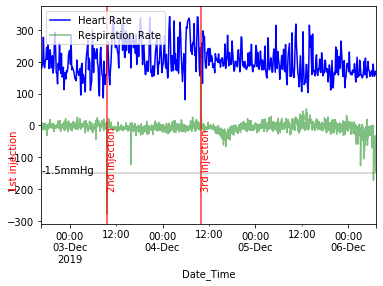

In [804]:
#set the injection time
t1 = pd.to_datetime("12/2/2019 8:15:00 AM") 
t2 = pd.to_datetime("12/3/2019 9:45:00 AM") 
t3 = pd.to_datetime("12/4/2019 10:00:00 AM") 

#quick look at the data
print("The shape of data is: ", data.shape)
data["HR"].resample("10T").mean().plot(color="b",alpha=1)
(data["Resp"]*10).resample("1T").mean().plot(color="g",alpha=0.5)
plt.legend(["Heart Rate", "Respiration Rate"],
          loc="upper left")
plt.axvline(t1, alpha=0.8, color ="red")
plt.text(t1,-200,'1st injection', color ="red",rotation=90)
plt.axvline(t2, alpha=0.8, color ="red")
plt.text(t2,-200,'2nd injection', color ="red",rotation=90)
plt.axvline(t3, alpha=0.8, color ="red")
plt.text(t3,-200,'3rd injection', color ="red",rotation=90)
plt.axhline(-150, alpha=0.2, color ="black")
plt.text(data.index[0],-150,'-1.5mmHg', color ="black")

In [795]:
#calculate the baseline for 1st injection
baseline_HR_1 = data.loc[:t1].HR.mean()
print('The baseline for 1st injection is {}'.format(baseline_HR_1))
data = data.loc[t1-pd.to_timedelta("1D"):]

#find the label time for septic status #for only 1 peek
inflation = pd.DataFrame((data["HR"]/baseline_HR_1*100).resample("10T").mean())
print("The cut-off for 1st injection is {}".format(inflation[t1:t1+pd.to_timedelta("8H")].idxmax(axis=0)))

#find the label time for recovery status
injection_rec_1 = inflation[inflation[t1:t1+pd.to_timedelta("8H")].HR.idxmax(axis=0):t2]
print("The cut-off for 1st recovery is {}".format(injection_rec_1[injection_rec_1.HR<110].first_valid_index()))

The baseline for 1st injection is 151.92351169305195
The cut-off for 1st injection is HR   2019-07-08 11:10:00
dtype: datetime64[ns]
The cut-off for 1st recovery is 2019-07-08 16:30:00


The shape of data is:  (867429, 3)


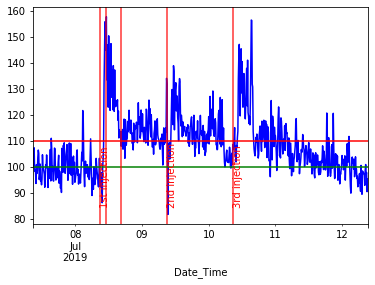

In [796]:
#zoom in the experiment area
print("The shape of data is: ", data.shape)
(data["HR"]/baseline_HR_1*100).resample("10T").mean().plot(color="b",alpha=1)
plt.axvline(t1, alpha=0.8, color ="red")
plt.text(t1,85,'1st injection', color ="red",rotation=90)
plt.axvline(t2, alpha=0.8, color ="red")
plt.text(t2,85,'2nd injection', color ="red",rotation=90)
plt.axvline(t3, alpha=0.8, color ="red")
plt.text(t3,85,'3rd injection', color ="red",rotation=90)

plt.axhline(100, color ="green")
plt.axhline(110, color ="red")

#adjust the plot here:
t4 = pd.to_datetime("2019-07-08 11:10:00")
t5 = pd.to_datetime("2019-07-08 16:30:00")

plt.axvline(t4, alpha=0.8, color ="red")
plt.axvline(t5, alpha=0.8, color ="red")

In [778]:
#for those with 2 peeks
first_peek = pd.to_datetime("2019-09-16 13:40:00")+pd.to_timedelta("20T")
print(inflation[first_peek:t1+pd.to_timedelta("8H")].idxmax(axis=0))

#find the label time for recovery status
injection_rec_1 = inflation[inflation[first_peek:t1+pd.to_timedelta("8H")].HR.idxmax(axis=0):t2]
print(injection_rec_1[injection_rec_1.HR<110].first_valid_index())


HR   2019-09-16 16:00:00
dtype: datetime64[ns]
2019-09-16 16:10:00


In [797]:
#find the cut-off value for the 2nd injection
baseline_HR_2 = data.loc[t2-pd.to_timedelta("4H"):t2].HR.mean()
print('The baseline for 2nd injection is {}'.format(baseline_HR_2))

#find the label time for septic status
inflation = pd.DataFrame((data["HR"]/baseline_HR_2*100).resample("10T").mean())
print("The cut-off for 2nd injection is {}".format(inflation[t2:t2+pd.to_timedelta("8H")].idxmax(axis=0)))

#find the label time for recovery status
injection_rec_2 = inflation[inflation[t2:t2+pd.to_timedelta("8H")].HR.idxmax(axis=0):t3]
print("The cut-off for 2nd recovery is {}".format(injection_rec_2[injection_rec_2.HR<110].first_valid_index()))

The baseline for 2nd injection is 168.3721022322917
The cut-off for 2nd injection is HR   2019-07-09 11:20:00
dtype: datetime64[ns]
The cut-off for 2nd recovery is 2019-07-09 11:40:00


The shape of data is:  (867429, 3)


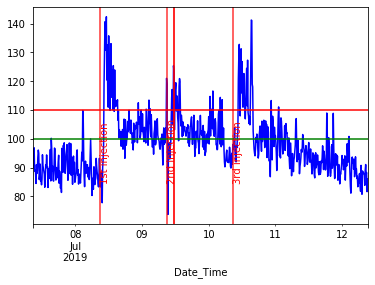

In [798]:
#zoom in the experiment area
print("The shape of data is: ", data.shape)
(data["HR"]/baseline_HR_2*100).resample("10T").mean().plot(color="b",alpha=1)
plt.axvline(t1, alpha=0.8, color ="red")
plt.text(t1,85,'1st injection', color ="red",rotation=90)
plt.axvline(t2, alpha=0.8, color ="red")
plt.text(t2,85,'2nd injection', color ="red",rotation=90)
plt.axvline(t3, alpha=0.8, color ="red")
plt.text(t3,85,'3rd injection', color ="red",rotation=90)

plt.axhline(100, color ="green")
plt.axhline(110, color ="red")

#adjust the plot here:
t4 = pd.to_datetime("2019-07-09 11:20:00")
t5 = pd.to_datetime("2019-07-09 11:40:00")

plt.axvline(t4, alpha=0.8, color ="red")
plt.axvline(t5, alpha=0.8, color ="red")

In [799]:
#find the cut-off value for the 3rd injection
baseline_HR_3 = data.loc[t3-pd.to_timedelta("4H"):t3].HR.mean()
print('The baseline for 3rd injection is {}'.format(baseline_HR_3))

#find the label time for septic status
inflation = pd.DataFrame((data["HR"]/baseline_HR_3*100).resample("10T").mean())
print("The cut-off for 3rd injection is {}".format(inflation[t3:t3+pd.to_timedelta("8H")].idxmax(axis=0)))

#find the label time for recovery status
injection_rec_3 = inflation[inflation[t3:t3+pd.to_timedelta("8H")].HR.idxmax(axis=0):]
print("The cut-off for 3rd recovery is {}".format(injection_rec_3[injection_rec_3.HR<110].first_valid_index()))

The baseline for 3rd injection is 160.02728765037006
The cut-off for 3rd injection is HR   2019-07-10 15:20:00
dtype: datetime64[ns]
The cut-off for 3rd recovery is 2019-07-10 16:00:00


The shape of data is:  (867429, 3)


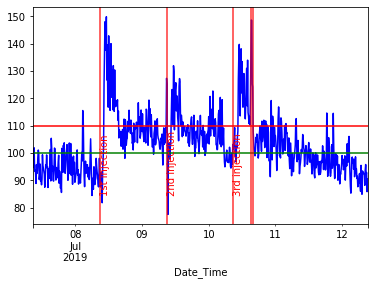

In [800]:
#zoom in the experiment area
print("The shape of data is: ", data.shape)
(data["HR"]/baseline_HR_3*100).resample("10T").mean().plot(color="b",alpha=1)
plt.axvline(t1, alpha=0.8, color ="red")
plt.text(t1,85,'1st injection', color ="red",rotation=90)
plt.axvline(t2, alpha=0.8, color ="red")
plt.text(t2,85,'2nd injection', color ="red",rotation=90)
plt.axvline(t3, alpha=0.8, color ="red")
plt.text(t3,85,'3rd injection', color ="red",rotation=90)

plt.axhline(100, color ="green")
plt.axhline(110, color ="red")

#adjust the plot here:
t4 = pd.to_datetime("2019-07-10 15:20:00")
t5 = pd.to_datetime("2019-07-10 16:00:00")

plt.axvline(t4, alpha=0.8, color ="red")
plt.axvline(t5, alpha=0.8, color ="red")

## change the label

In [903]:
#label for lps+saline group
import os
from glob import glob
PATH = "/Users/leeo/Desktop/KI2/7.master_thesis/1.data/12.feature_label_4h_control/control_group_fe//"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]

In [921]:
f= all_csv_files[5]
print(f)
data = pd.read_csv(f, sep=",", header=0,
                       parse_dates=[0], index_col=0)
data.start_time =pd.to_datetime(data.start_time)
data.end_time =pd.to_datetime(data.end_time)
data["AnimalID"]=f[-9:-4] #add the animal ID here
print(data["label"].value_counts())
data.head()

/Users/leeo/Desktop/KI2/7.master_thesis/1.data/12.feature_label_4h_control/control_group_fe/general_fe_18279.csv
0.0    8844
Name: label, dtype: int64


,amplitude,amplitude.1,max_slope,max_slope.1,mean,mean.1,maximum,maximum.1,median,median.1,minimum,minimum.1,skew,skew.1,std,std.1,start_time,end_time,label,AnimalID
feature,,,,,,,,,,,,,,,,,,,,
channel,0.00000,1.000000,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000,1.000000,0.00000,1.000000,0.0000,1.000000,0.000000,1.000000,0.000000,1.000000,NaT,NaT,NaN,18279
0,178.59635,4.172562,4.539630e-07,4.912603e-09,188.264556,4.065207,375.353,9.342205,190.38975,3.763445,18.1603,0.997082,-2.316868,1.423077,34.749220,1.075517,2018-11-30 16:00:00.322920,2018-11-30 16:10:00.322920,0.0,18279
1,178.59635,4.172562,4.539630e-07,4.912603e-09,187.531826,3.958175,375.353,9.342205,189.07815,3.670735,18.1603,0.997082,-2.261143,1.350979,34.714119,1.079191,2018-11-30 16:01:00.322920,2018-11-30 16:11:00.322920,0.0,18279
2,178.59635,4.892341,4.539630e-07,6.659759e-09,187.928782,3.874492,375.353,9.342205,189.21035,3.551547,18.1603,-0.442478,-1.950869,1.162861,35.674215,1.130417,2018-11-30 16:02:00.322920,2018-11-30 16:12:00.322920,0.0,18279
3,178.59635,4.892341,4.539630e-07,6.659759e-09,187.115907,3.673146,375.353,9.342205,187.69020,3.448183,18.1603,-0.442478,-1.894639,1.298512,35.362018,1.044723,2018-11-30 16:03:00.322920,2018-11-30 16:13:00.322920,0.0,18279


In [874]:
#1st injection
injection_1 = pd.to_datetime("9/16/2019 9:15:00 AM")
septic_1    = pd.to_datetime("9/16/2019 12:50:00 PM")
recovery_1  = pd.to_datetime("9/16/2019 2:10:00 PM")
for i in range(len(data)):
    if injection_1<=data.iloc[i]["start_time"]<=septic_1:
        data.iloc[i, data.columns.get_loc('label')] = 1
    if septic_1<data.iloc[i]["start_time"]<=recovery_1-pd.to_timedelta("10T"):
        data.iloc[i, data.columns.get_loc('label')] = 2
        

In [875]:
#2nd injection
injection_2 = pd.to_datetime("9/17/2019 9:20:00 AM")
septic_2    = pd.to_datetime("9/17/2019 12:50:00 PM")
recovery_2  = pd.to_datetime("9/17/2019 1:00:00 PM")
for i in range(len(data)):
    if injection_2<=data.iloc[i]["start_time"]<=septic_2:
        data.iloc[i, data.columns.get_loc('label')] = 1
    if septic_2<data.iloc[i]["start_time"]<=recovery_2-pd.to_timedelta("10T"):
        data.iloc[i, data.columns.get_loc('label')] = 2
        

In [876]:
#3rd injection
injection_3 = pd.to_datetime("9/18/2019 9:40:00 AM")
septic_3    = pd.to_datetime("9/18/2019 4:30:00 PM")
recovery_3  = pd.to_datetime("9/18/2019 5:10:00 PM")
for i in range(len(data)):
    if injection_3<=data.iloc[i]["start_time"]<=septic_3:
        data.iloc[i, data.columns.get_loc('label')] = 1
    if septic_3<data.iloc[i]["start_time"]<=recovery_3-pd.to_timedelta("10T"):
        data.iloc[i, data.columns.get_loc('label')] = 2
        

In [877]:
data["label"].value_counts()

0.0    12728
1.0      835
2.0      100
Name: label, dtype: int64

In [919]:
#export the data
data.to_csv(f, header=True)
print("The data have been exported to {}.".format(f))

The data have been exported to /Users/leeo/Desktop/KI2/7.master_thesis/1.data/12.feature_label_4h_control/control_group_fe/general_fe_18279.csv.


## Combine the data within the same group


In [928]:
PATH = "/Users/leeo/Desktop/KI2/7.master_thesis/1.data/12.feature_label_4h_control/combine_fe/"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]

In [932]:
combined_data = []
for f in all_csv_files:
    data = pd.read_csv(f, sep=",", header=0,
                   parse_dates=[0], index_col=0)
    # store DataFrame in list
    combined_data.append(data)
combined_data = pd.concat(combined_data)
combined_data["label"].value_counts()

0.0    193851
1.0     10622
2.0      3504
Name: label, dtype: int64

In [930]:
print(combined_data.columns)
combined_data.head()

Index(['amplitude', 'amplitude.1', 'max_slope', 'max_slope.1', 'mean',
       'mean.1', 'maximum', 'maximum.1', 'median', 'median.1', 'minimum',
       'minimum.1', 'skew', 'skew.1', 'std', 'std.1', 'label', 'AnimalID'],
      dtype='object')


,amplitude,amplitude.1,max_slope,max_slope.1,mean,mean.1,maximum,maximum.1,median,median.1,minimum,minimum.1,skew,skew.1,std,std.1,label,AnimalID
0,51.813675,4.311116,3.792480e-08,5.623065e-09,121.711396,0.857965,189.7301,6.008276,116.39075,0.719275,86.10275,-2.613956,0.791889,1.254870,18.539590,0.851054,0.0,18273
1,40.914125,4.311116,3.792480e-08,5.623065e-09,117.490006,0.822269,167.9310,6.008276,113.97215,0.699203,86.10275,-2.613956,0.414415,1.247098,14.281150,0.798566,0.0,18273
2,45.142925,4.311116,3.792480e-08,5.623065e-09,117.739714,0.833094,176.3886,6.008276,113.97215,0.725558,86.10275,-2.613956,0.815078,1.204496,15.281734,0.800085,0.0,18273
3,45.142925,3.722035,3.792480e-08,5.623065e-09,118.713991,0.807083,176.3886,4.830114,114.24500,0.768526,86.10275,-2.613956,0.723899,0.521320,16.199469,0.715808,0.0,18273
4,45.142925,3.722035,3.792480e-08,5.623065e-09,118.643321,0.768451,176.3886,4.830114,114.37730,0.716615,86.10275,-2.613956,0.746583,0.429821,16.010048,0.719934,0.0,18273


In [933]:
#combined_data = combined_data.drop(columns="start_time")
#combined_data = combined_data.drop(columns="end_time")
#combined_data = combined_data.drop("channel")
#combined_data = combined_data.drop(["channel","4104"])
df = combined_data.reset_index(drop=True)
df["label"].value_counts()

0.0    193851
1.0     10622
2.0      3504
Name: label, dtype: int64

In [934]:
#export the data
exf=PATH+"all_group.csv"
df.to_csv(exf, header=True)
print("The data have been exported to {}.".format(exf))

The data have been exported to /Users/leeo/Desktop/KI2/7.master_thesis/1.data/12.feature_label_4h_control/combine_fe/all_group.csv.
